In [56]:
# from pyspark.ml.clustering import KMeans, KMeansModel
# from pyspark.mllib.clustering import KMeans, KMeansModel
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SparkSession
# import sys, re
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.linalg import Vectors
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [57]:
spark_session = SparkSession.builder.master("local").appName("pairrdd-op-test1").getOrCreate()
sc = spark_session.sparkContext
data = sc.textFile("./loc-sample.txt")

In [58]:
data = data.map(lambda line: line.split("\t"))\
            .map(lambda line: (int(line[0]), line[1], float(line[2]), float(line[3]), int(line[4])))

data = data.map(lambda x: (x[0], datetime.strptime(x[1], "%Y-%m-%dT%H:%M:%SZ"), x[2], x[3], x[4]))

data = data.map(lambda x: ((x[1].year, x[1].month), (Vectors.dense([x[2], x[3]]))))
grouped_data = data.groupByKey()

In [59]:
hot_places = {}

for (year, month), vectors in grouped_data.collect():
    vectors = list(vectors)

    model = KMeans.train(sc.parallelize(vectors), 10)

    predictions = model.predict(sc.parallelize(vectors))
    cluster_counts = predictions.countByValue()


    top2 = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)[:2]

    hot_places[(year, month)] = [model.clusterCenters[c[0]] for c in top2]

In [60]:
print(hot_places)
print(top2)
print(cluster_counts)

{(2010, 10): [array([ 40.726546  , -74.00247554]), array([ 30.26913944, -97.74973543])], (2010, 9): [array([  34.08070925, -118.26316372]), array([  37.78999064, -122.36189655])], (2010, 8): [array([ 30.26777191, -97.74730488]), array([ 30.24816814, -97.75098974])], (2010, 7): [array([ 30.26383194, -97.74241085]), array([  39.19857582, -106.83199136])], (2010, 6): [array([ 30.25791522, -97.74800968]), array([  37.78355246, -122.40299103])], (2010, 5): [array([ 30.26850627, -97.74935389]), array([ 30.24485972, -97.75716305])]}
[(0, 2), (8, 1)]
defaultdict(<class 'int'>, {8: 1, 1: 1, 0: 2, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1})


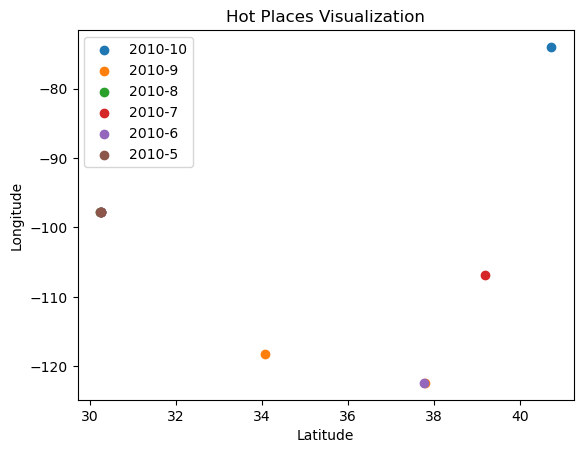

In [61]:
for (year_month, locations) in hot_places.items():
    plt.scatter(*zip(*locations), label=f"{year_month[0]}-{year_month[1]}")

plt.legend()
plt.title("Hot Places Visualization")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

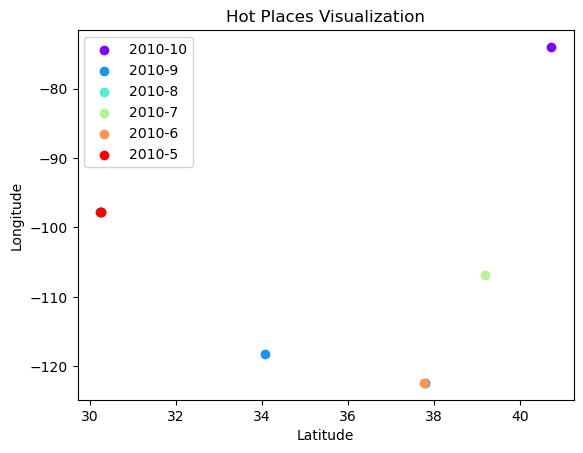

In [62]:
# hot place 시각화
colors = plt.cm.rainbow(np.linspace(0, 1, len(hot_places)))
for (year_month, locations), color in zip(hot_places.items(), colors):
    plt.scatter(*zip(*locations), color=color, label=f"{year_month[0]}-{year_month[1]}")

plt.legend()
plt.title("Hot Places Visualization")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()